In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import FinanceDataReader as fdr

# 시각화 사용자 설정
from matplotlib import rcParams
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance as xgb_plot_importance
from lightgbm import plot_importance as lgb_plot_importance

In [2]:
def graph(df, cols, axv_list=[]) :
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.lineplot(data=df[cols])
    
    plt.title('compare : ' + (', '.join(cols)), fontsize=20)
    plt.ylabel('Value', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.legend(fontsize=12, loc='best')
    
    if axv_list != [] :
        for i in axv_list :
            if len(i) == 4 :
                color = i[3]
            else :
                color = 'b'
            plt.axvline(x=datetime(i[0], i[1], i[2]), color=color, linestyle='--', linewidth=1)

    plt.show()
    return

### 이진분류 머신러닝 / MLP 함수 정의

In [3]:
def machineLearning_Classifier(X_train, y_train, X_test, y_test) :
    neighbor_model = KNeighborsClassifier(n_neighbors=5)
    svm_model = SVC()
    forest_model = RandomForestClassifier(n_estimators=300)
    gbm_model = GradientBoostingClassifier(random_state=10)
    xgb_model = XGBClassifier(n_estimators=300, eval_metric = "logloss")
    lgb_model = LGBMClassifier(n_estimators=300)

    model_list = [neighbor_model, svm_model, forest_model, gbm_model, xgb_model, lgb_model]

    for model in model_list:
        model_name = model.__class__.__name__
        model.fit(X_train , y_train)
        print('\n{0} 학습데이터셋 정확도: {1:.4f}'.format(model_name, model.score(X_train , y_train)))

        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)    
        print('{0} 테스트셋 정확도: {1:.4f}'.format(model_name, accuracy)) 
    print()
    return model_list

def xgb_FeatureImportance(xgb_model) :
    print('-------------XGB Plot Importance-------------')
    plt.rc('font', family='NanumGothic') # For Windows
    fig, ax = plt.subplots(figsize=(10, 12))
    xgb_plot_importance(xgb_model, ax=ax)
    plt.show()
    return

def lgb_FeatureImportance(lgb_model) :
    print('-------------LGB Plot Importance-------------')
    plt.rc('font', family='NanumGothic') # For Windows
    fig, ax = plt.subplots(figsize=(10, 12))
    lgb_plot_importance(lgb_model, ax=ax)
    plt.show()
    return

def rf_FeatureImportance(forest_model, columns) :
    print('-------------FOREST Plot Importance-------------')
    plt.rc('font', family='NanumGothic') # For Windows
    features = columns
    importances = forest_model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots(figsize=(10, 12))
    plt.title('RandomForest Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return

def MLP_Classifier(input_dim, X_train, y_train, X_test, y_test) :
    model = Sequential()
    model.add(Dense(60, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=10)
    
    eval = model.evaluate(X_test, y_test)
    print('{0} 정확도: {1:.4f}, Loss: {2:.4f}'.format(model.__class__.__name__, eval[1], eval[0]))
    return model

### 회귀 머신러닝 / 딥러닝 함수 정의

In [4]:
def mse(y, pred):
    squared_error = (y - pred) ** 2
    mse = np.mean(squared_error)
    print('MSE: {0:.8f}'.format(mse))
    return mse

def machineLearning_Regression(X_train, y_train, X_test, y_test, drawGraph=True) :
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=500)
    gbm_model = GradientBoostingRegressor(n_estimators=500)
    xgb_model = XGBRegressor(n_estimators=500)
    lgbm_model = LGBMRegressor(n_estimators=500)

    model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
    for model in model_list:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print('###',model.__class__.__name__,'###')
        mse(y_test, pred)
        if drawGraph :
            tmpDf = pd.DataFrame(index=X_test.index)
            tmpDf['pred'] = pred
            tmpDf['y_test'] = y_test
            graph(tmpDf, tmpDf.columns.tolist())
    return model_list

def plotFeatureList(model, X):
    coef = pd.Series(model.coef_, index=X.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    plt.show()
    return

def MLP_Regression(input_dim, X_train, y_train, X_test, y_test, epochs=10, batch_size=10, drawGraph=True) :
    model = Sequential()
    model.add(Dense(60, input_dim= X_train.shape[1], activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                 metrics=['mse'])

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # 예측 값과 실제 값의 비교
    pred = model.predict(X_test).flatten()
    print('###',model.__class__.__name__,'###')
    mse(y_test, pred)    
    if drawGraph :
        tmpDf = pd.DataFrame(index=X_test.index)
        tmpDf['pred'] = pred
        tmpDf['y_test'] = y_test
        graph(tmpDf, tmpDf.columns.tolist())
    return model

### Feature 불러오기

In [27]:
df = pd.read_csv('./df.csv',  index_col=['Date'], parse_dates=True, encoding='euc-kr')
df

,samsung,usdkrw,sox,SK하이닉스,삼성전자우,오리온,DB하이텍,메리츠증권,넥센타이어,대교,인천도시가스,미래에셋 미국 시니어론 100 ETN,삼성 Alerian 에너지인프라 MLP ETN,KINDEX S&P아시아TOP50,KODEX 미국채10년선물,미래에셋 인버스 S&P500 ETN(H),미래에셋 인버스 전기전자 Core5 ETN,하나마이크론,디바이스이엔지,국전약품
Date,,,,,,,,,,,,,,,,,,,,
2018-12-20,-0.011509,-0.0061,-0.0069,-0.028192,-0.029595,-0.016667,-0.031250,0.000000,0.023454,0.002999,0.003328,0.000995,0.010360,-0.011188,-0.001942,0.024343,0.023102,-0.021477,-0.005243,0.002196
2018-12-21,0.000000,0.0056,-0.0170,0.023891,0.009631,-0.004237,-0.004608,-0.004464,0.002083,-0.008969,-0.001658,-0.007455,-0.024729,-0.000539,-0.005837,0.000000,-0.011290,0.013717,-0.002568,-0.002191
2018-12-24,0.003881,-0.0037,-0.0293,0.006667,-0.014308,0.000000,-0.013889,-0.007848,-0.004158,0.001508,-0.001661,-0.002504,-0.016698,0.001617,0.002446,0.025016,-0.013866,-0.004060,-0.017071,0.002196
2018-12-26,-0.011598,-0.0015,0.0600,-0.004967,0.000000,-0.021277,-0.032864,-0.019209,-0.032359,-0.003012,-0.003328,0.000000,-0.042138,-0.001615,0.004880,0.034777,0.017370,-0.008152,0.013370,0.007450
2018-12-27,-0.002608,-0.0032,0.0066,0.024958,0.012903,-0.008696,0.038835,-0.032258,-0.008630,-0.006042,-0.010017,-0.006526,0.043336,-0.001078,-0.008742,-0.053656,-0.022764,0.001370,0.013194,-0.002175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.029954,-0.0026,0.0014,0.050584,0.020619,0.037037,0.015896,0.016949,0.045524,-0.001314,0.006061,-0.000453,-0.013008,0.021308,-0.001748,0.005650,-0.002427,-0.008032,0.016913,-0.045191
2021-01-26,-0.030201,-0.0014,-0.0162,-0.044444,-0.013889,-0.023810,-0.042674,-0.019444,-0.036284,0.005263,-0.010040,0.000906,0.002471,-0.022892,0.007005,0.000000,0.014599,-0.028340,0.030146,0.031553
2021-01-27,-0.012687,0.0067,-0.0519,-0.003876,-0.010243,0.004065,-0.016345,0.007082,0.010542,-0.014398,-0.002028,0.000000,-0.005752,-0.005931,-0.001304,0.007865,0.011990,0.004167,-0.031282,-0.012941


### Y 값 정의 : 다음날에 오를까 / 내릴까

<AxesSubplot:xlabel='binClass', ylabel='count'>

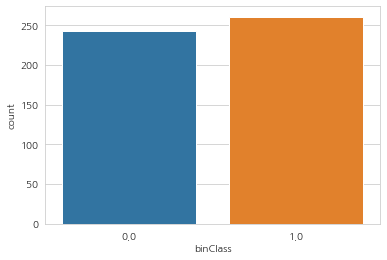

In [28]:
df['binClass'] = df.apply(lambda x : 1 if x['samsung'] > 0 else 0, axis=1)
df['binClass'] = df['binClass'].shift(-1)
df.dropna(inplace=True, axis=0)
sns.countplot(df['binClass'])

### X, Y 를 train, test 로 분류

In [29]:
Y = df['binClass']
X = df.drop(['binClass'], axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=0)

### 머신러닝 (이진분류)


KNeighborsClassifier 학습데이터셋 정확도: 0.7216
KNeighborsClassifier 테스트셋 정확도: 0.5526

SVC 학습데이터셋 정확도: 0.7386
SVC 테스트셋 정확도: 0.6118

RandomForestClassifier 학습데이터셋 정확도: 1.0000
RandomForestClassifier 테스트셋 정확도: 0.5132

GradientBoostingClassifier 학습데이터셋 정확도: 1.0000
GradientBoostingClassifier 테스트셋 정확도: 0.4539

XGBClassifier 학습데이터셋 정확도: 1.0000
XGBClassifier 테스트셋 정확도: 0.5461

LGBMClassifier 학습데이터셋 정확도: 1.0000
LGBMClassifier 테스트셋 정확도: 0.5461

-------------XGB Plot Importance-------------


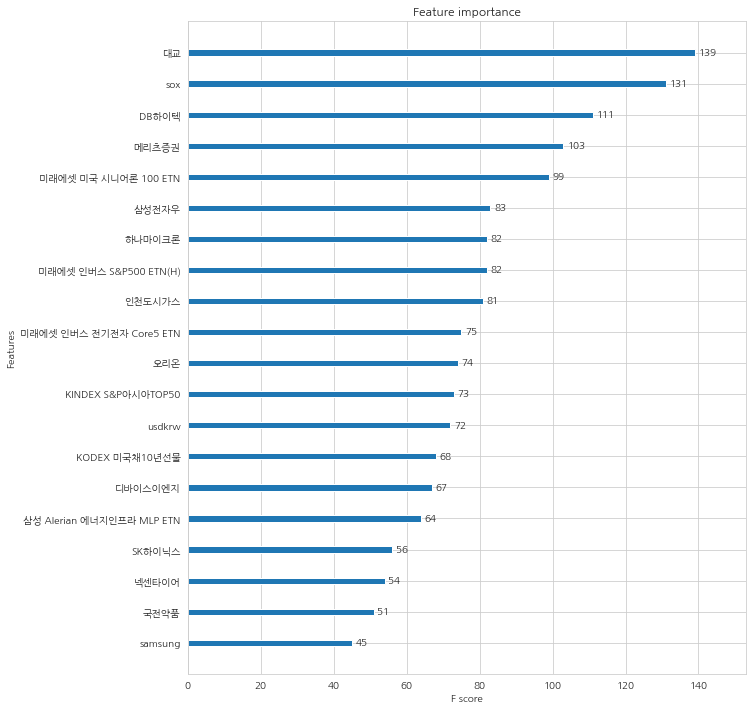

-------------LGB Plot Importance-------------


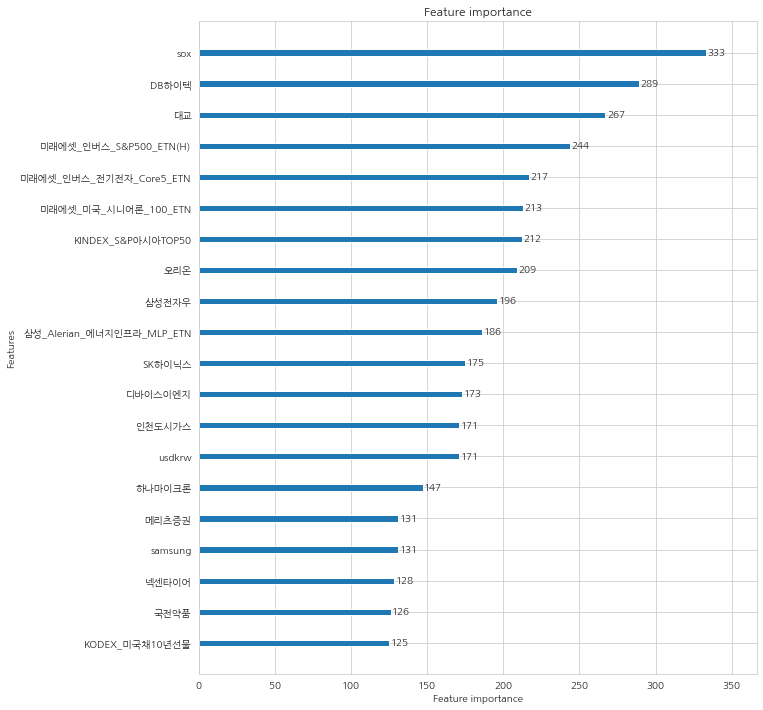

-------------FOREST Plot Importance-------------


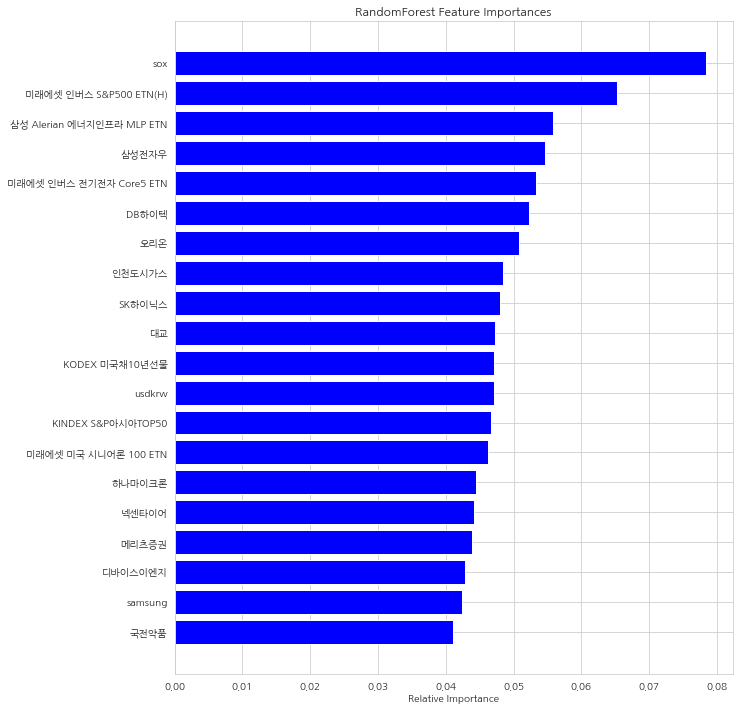

In [30]:
model_list = machineLearning_Classifier(X_train, y_train, X_test, y_test)

for model in model_list :
    if model.__class__.__name__ == 'XGBClassifier' :
        xgb_model = model
    if model.__class__.__name__ == 'LGBMClassifier' :
        lgb_model = model
    if model.__class__.__name__ == 'RandomForestClassifier' :
        forest_model = model
columns = X.columns

xgb_FeatureImportance(xgb_model)
lgb_FeatureImportance(lgb_model)
rf_FeatureImportance(forest_model, columns)

### 딥러닝 (이진분류)

In [31]:
MLP_Classifier(len(X.columns), X_train, y_train, X_test, y_test)

Epoch 1/10
36/36 [==============================] - 0s 916us/step - loss: 0.6947 - accuracy: 0.4688
Epoch 2/10
36/36 [==============================] - 0s 833us/step - loss: 0.6919 - accuracy: 0.5341
Epoch 3/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6905 - accuracy: 0.5511
Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5625
Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.5710
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.5682
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5767
Epoch 8/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6834 - accuracy: 0.5795
Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.5966
Epoch 10/10
5/5 [==============================] - 0s 999us/step - loss: 0.6858 - accuracy: 0.5526
Sequential 정확도:

### PCA로 차원 축소

In [32]:
# https://m.blog.naver.com/PostView.nhn?blogId=tjdrud1323&logNo=221720259834&proxyReferer=https:%2F%2Fwww.google.com%2F
from sklearn.decomposition import PCA

n_components = 18 # 주성분을 몇개로 할지 결정
columns = ['PCA_'+str(x) for x in range(0, n_components)]

pca = PCA(n_components=n_components) 
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = columns, index=X.index)
print(f'주성분 {n_components}개로 전체 데이터의 분산을 {str(sum(pca.explained_variance_ratio_)*100)}만큼 설명')
principalDf.head()

주성분 18개로 전체 데이터의 분산을 99.76417213657331만큼 설명


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17
Date,,,,,,,,,,,,,,,,,,
2018-12-20,0.049681,0.006948,-0.027115,-0.019699,0.014368,0.021695,0.005823,0.012603,0.006171,0.029148,-0.018146,-0.011444,0.013063,-0.004908,0.007577,-0.003646,0.013269,-0.009382
2018-12-21,-0.002367,-0.007393,0.014103,0.005326,0.001181,0.005071,-0.017469,-0.011601,-0.032978,0.001117,-0.000983,-0.009777,-0.005911,0.003656,-0.001085,0.003817,0.001464,0.009581
2018-12-24,0.028421,-0.000676,0.008482,-0.007456,0.001784,0.011163,-0.000942,-0.013823,-0.030384,-0.000162,-0.001679,-0.017786,0.008794,0.021839,-0.002388,-0.008002,0.008782,-0.007401
2018-12-26,0.039083,0.011680,0.003731,0.051256,-0.024957,0.034822,-0.035588,0.039531,0.022974,-0.006475,0.003012,-0.012301,0.021781,0.002053,-0.000296,-0.006176,0.000554,0.010619
2018-12-27,-0.026224,-0.003377,-0.008386,0.002616,0.004307,-0.057085,0.008360,0.007600,-0.000031,-0.036337,-0.020768,0.021954,-0.041161,-0.002525,-0.002042,0.021615,0.000903,0.005722


In [33]:
# PCA 한 DF 로 다시 학습
X_train, X_test, y_train, y_test = train_test_split(principalDf, Y, test_size=0.3, shuffle=False, random_state=0)

model_list = machineLearning_Classifier(X_train, y_train, X_test, y_test)


KNeighborsClassifier 학습데이터셋 정확도: 0.7131
KNeighborsClassifier 테스트셋 정확도: 0.5461

SVC 학습데이터셋 정확도: 0.7273
SVC 테스트셋 정확도: 0.6053

RandomForestClassifier 학습데이터셋 정확도: 1.0000
RandomForestClassifier 테스트셋 정확도: 0.6250

GradientBoostingClassifier 학습데이터셋 정확도: 1.0000
GradientBoostingClassifier 테스트셋 정확도: 0.5592

XGBClassifier 학습데이터셋 정확도: 1.0000
XGBClassifier 테스트셋 정확도: 0.5592

LGBMClassifier 학습데이터셋 정확도: 1.0000
LGBMClassifier 테스트셋 정확도: 0.5526



In [35]:
MLP_Classifier(len(principalDf.columns), X_train, y_train, X_test, y_test)

Epoch 1/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5085
Epoch 2/10
36/36 [==============================] - 0s 916us/step - loss: 0.6902 - accuracy: 0.5455
Epoch 3/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5426
Epoch 4/10
36/36 [==============================] - 0s 999us/step - loss: 0.6871 - accuracy: 0.5540
Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6855 - accuracy: 0.5511
Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.5994
Epoch 7/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6840 - accuracy: 0.6165
Epoch 8/10
36/36 [==============================] - 0s 1ms/step - loss: 0.6810 - accuracy: 0.5625
Epoch 9/10
36/36 [==============================] - 0s 916us/step - loss: 0.6793 - accuracy: 0.5710
Epoch 10/10
5/5 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5724
Sequential 정확도:

### Y 값 정의 : 다음날에 얼마나 오를까

In [36]:
df = pd.read_csv('./df.csv',  index_col=['Date'], parse_dates=True, encoding='euc-kr')
df['predChange'] = df['samsung'].shift(-1)
df.dropna(inplace=True, axis=0)

Y = df['predChange']
X = df.drop(['predChange'], axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=0)

y_test의 평균값(0.0033353613292691495)으로 매일 예측했을 때의 MSE는 다음과 같다.
MSE: 0.00033065
즉, 위 값보다 작은 MSE 가 나와야 함.

### LinearRegression ###
MSE: 0.00048862


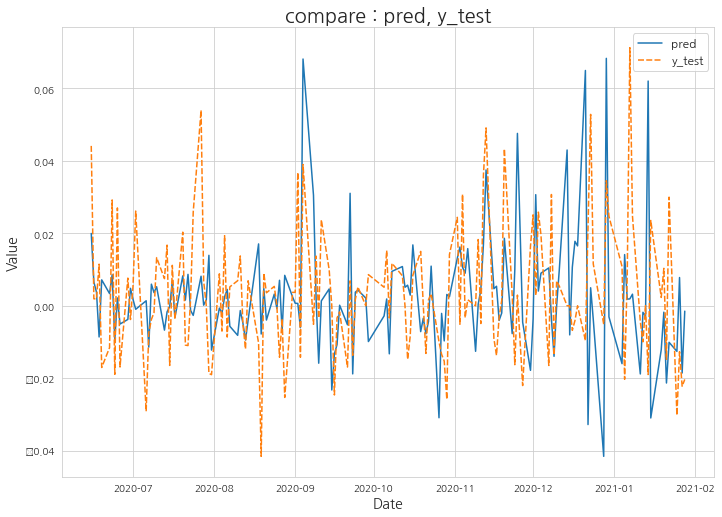

### RandomForestRegressor ###
MSE: 0.00035588


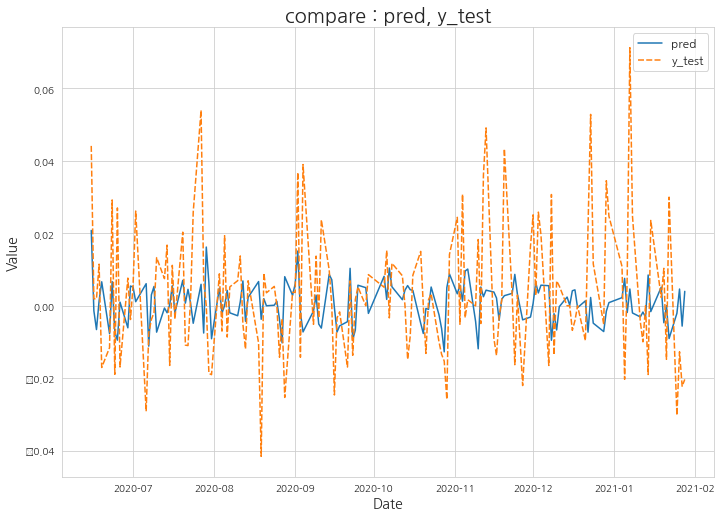

### GradientBoostingRegressor ###
MSE: 0.00044228


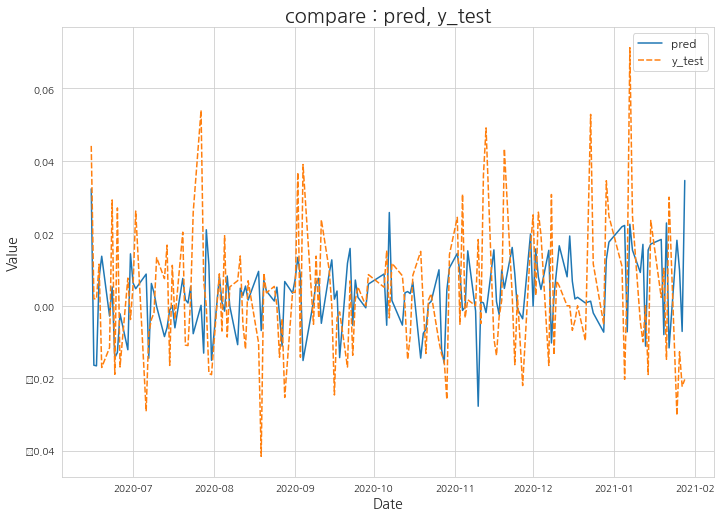

### XGBRegressor ###
MSE: 0.00043018


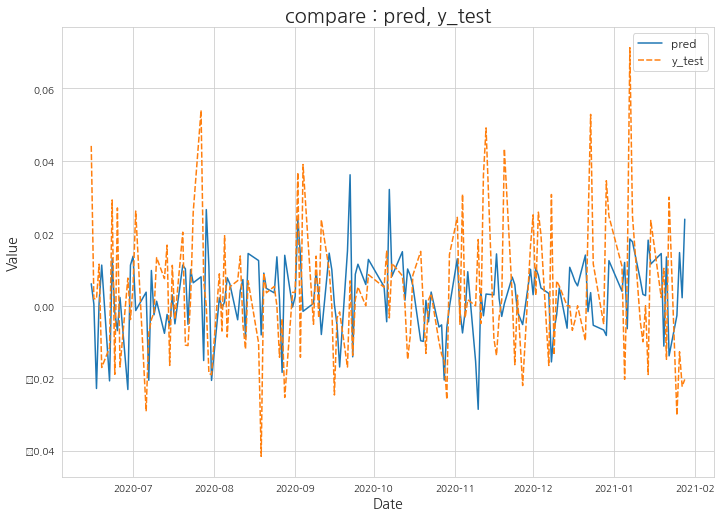

### LGBMRegressor ###
MSE: 0.00039867


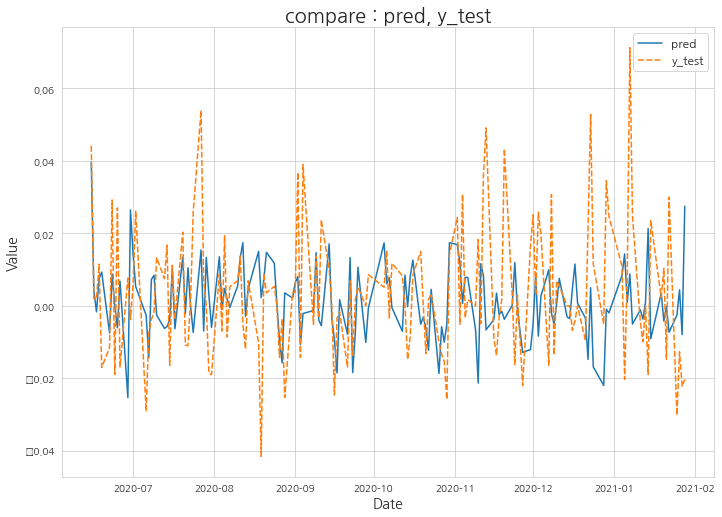

In [37]:
# 기준선 : 매일 변화율의 평균으로 예측했을 때의 MSE
changeMean = y_test.mean()
print(f"y_test의 평균값({changeMean})으로 매일 예측했을 때의 MSE는 다음과 같다.")
mse(y_test, changeMean)
print("즉, 위 값보다 작은 MSE 가 나와야 함.\n")

model_list = machineLearning_Regression(X_train, y_train, X_test, y_test)

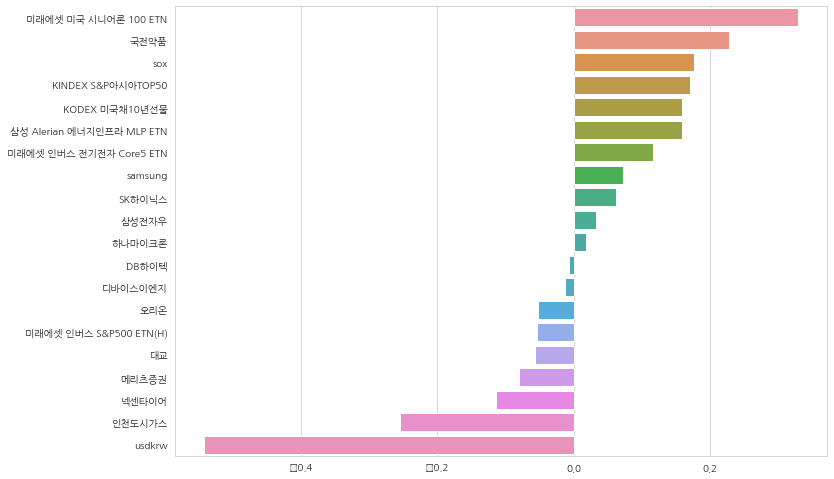

In [38]:
# 선형회귀모델에서 가장 영향을 많이 주는 종속변수
for model in model_list :
    if model.__class__.__name__ == 'LinearRegression' :
        lr_model = model
columns = X.columns

plotFeatureList(lr_model, X)

Epoch 1/10
36/36 [==============================] - 0s 942us/step - loss: 3.5307e-04 - mse: 3.5307e-04
Epoch 2/10
36/36 [==============================] - 0s 972us/step - loss: 3.2444e-04 - mse: 3.2444e-04
Epoch 3/10
36/36 [==============================] - 0s 916us/step - loss: 2.9613e-04 - mse: 2.9613e-04
Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 2.7828e-04 - mse: 2.7828e-04
Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 2.7246e-04 - mse: 2.7246e-04
Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 2.5174e-04 - mse: 2.5174e-04
Epoch 7/10
36/36 [==============================] - 0s 1ms/step - loss: 2.4670e-04 - mse: 2.4670e-04
Epoch 8/10
36/36 [==============================] - 0s 1ms/step - loss: 2.4789e-04 - mse: 2.4789e-04
Epoch 9/10
36/36 [==============================] - 0s 1ms/step - loss: 2.4508e-04 - mse: 2.4508e-04
Epoch 10/10
36/36 [==============================] - 0s 1ms/step - loss: 2.7306e-04 -

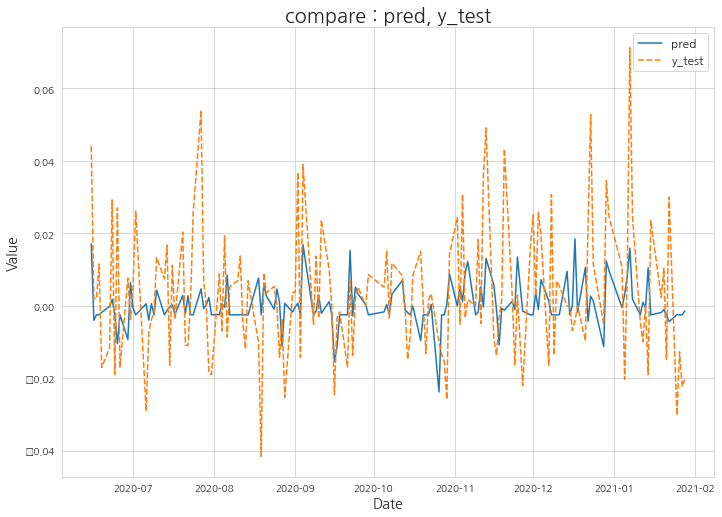

In [39]:
MLP_Regression(len(X.columns), X_train, y_train, X_test, y_test, epochs=10, batch_size=10)

In [40]:
# PCA로 차원 축소
n_components = 19
columns = ['PCA_'+str(x) for x in range(0, n_components)]

pca = PCA(n_components=n_components) 
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = columns, index=X.index)
print(f'주성분 {n_components}개로 전체 데이터의 분산을 {str(sum(pca.explained_variance_ratio_)*100)}만큼 설명')
principalDf.head()

주성분 19개로 전체 데이터의 분산을 99.90334811355306만큼 설명


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
Date,,,,,,,,,,,,,,,,,,,
2018-12-20,0.049681,0.006948,-0.027115,-0.019699,0.014368,0.021695,0.005823,0.012603,0.006171,0.029148,-0.018146,-0.011444,0.013063,-0.004908,0.007577,-0.003646,0.013269,-0.009382,-0.004753
2018-12-21,-0.002367,-0.007393,0.014103,0.005326,0.001181,0.005071,-0.017469,-0.011601,-0.032978,0.001117,-0.000983,-0.009777,-0.005911,0.003656,-0.001085,0.003817,0.001464,0.009581,0.000020
2018-12-24,0.028421,-0.000676,0.008482,-0.007456,0.001784,0.011163,-0.000942,-0.013823,-0.030384,-0.000162,-0.001679,-0.017786,0.008794,0.021839,-0.002388,-0.008002,0.008782,-0.007401,0.001173
2018-12-26,0.039083,0.011680,0.003731,0.051256,-0.024957,0.034822,-0.035588,0.039531,0.022974,-0.006475,0.003012,-0.012301,0.021781,0.002053,-0.000296,-0.006176,0.000554,0.010619,-0.001170
2018-12-27,-0.026224,-0.003377,-0.008386,0.002616,0.004307,-0.057085,0.008360,0.007600,-0.000031,-0.036337,-0.020768,0.021954,-0.041161,-0.002525,-0.002042,0.021615,0.000903,0.005722,-0.003015


### LinearRegression ###
MSE: 0.00056003


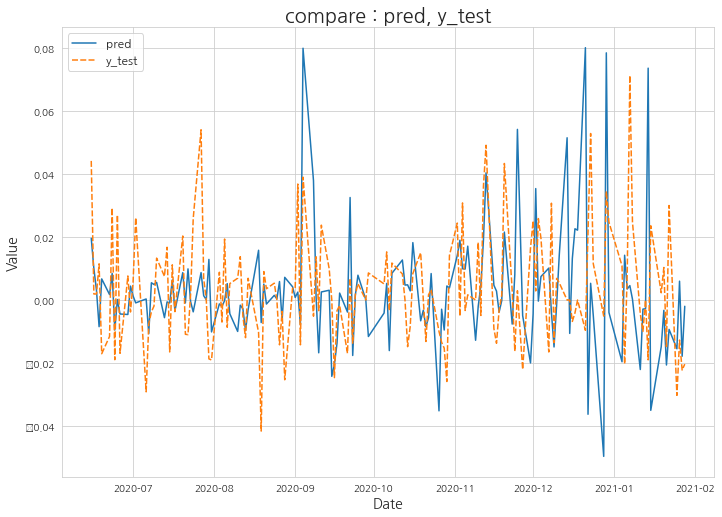

### RandomForestRegressor ###
MSE: 0.00031209


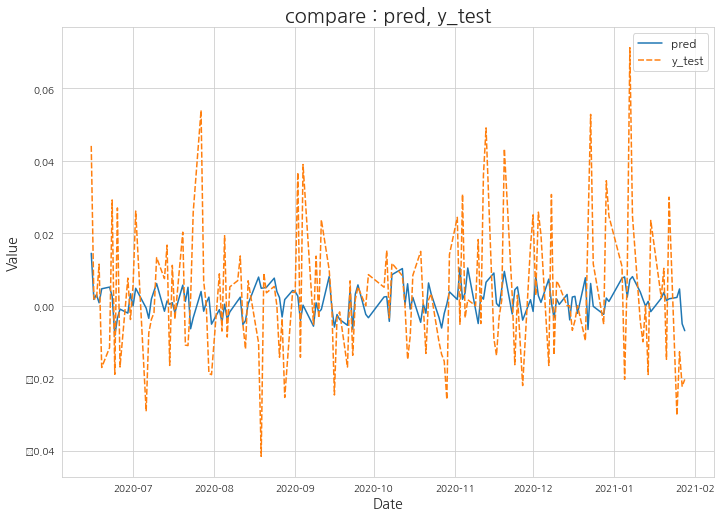

### GradientBoostingRegressor ###
MSE: 0.00037143


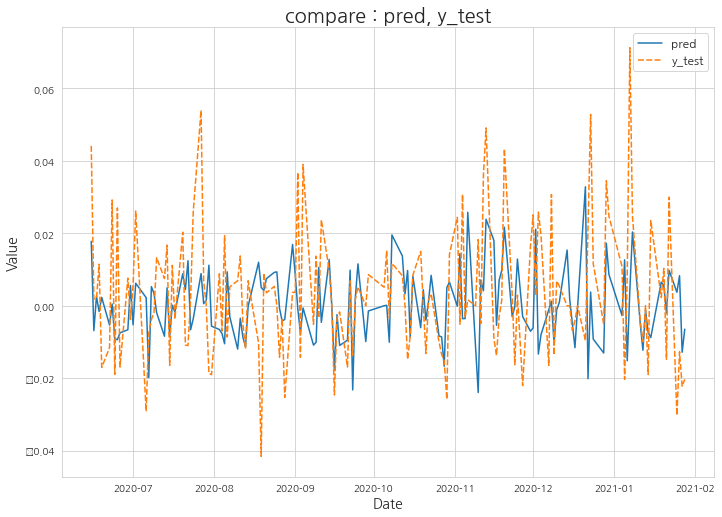

### XGBRegressor ###
MSE: 0.00036320


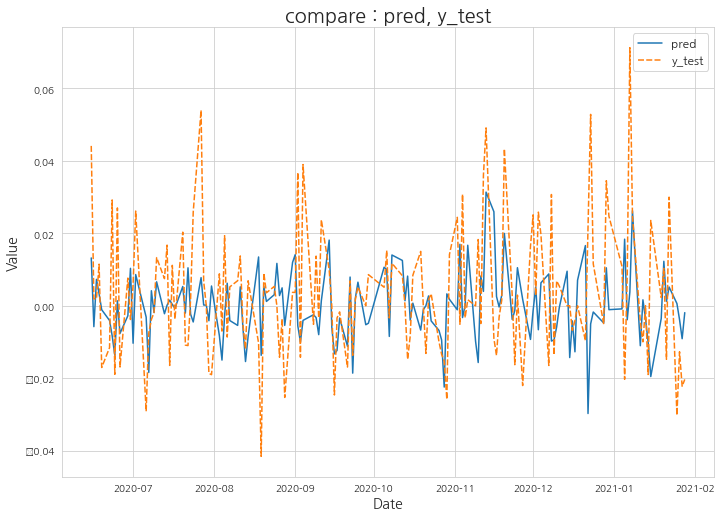

### LGBMRegressor ###
MSE: 0.00038913


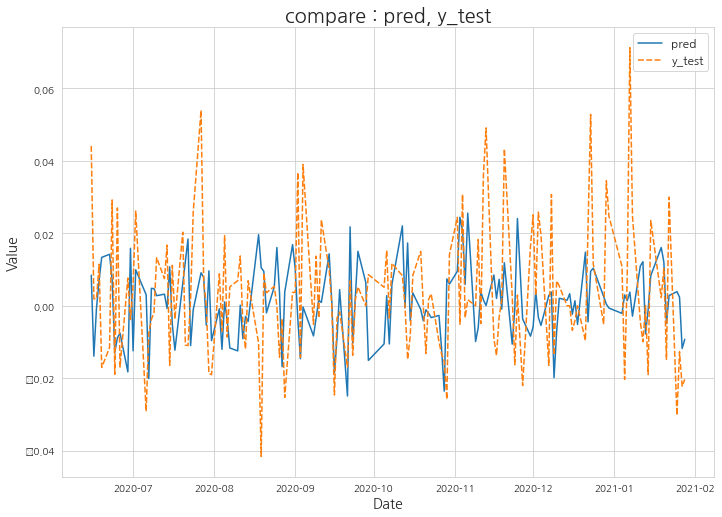

In [41]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, Y, test_size=0.3, shuffle=False, random_state=0)

model_list = machineLearning_Regression(X_train, y_train, X_test, y_test)

Epoch 1/10
36/36 [==============================] - 0s 916us/step - loss: 3.7013e-04 - mse: 3.7013e-04
Epoch 2/10
36/36 [==============================] - 0s 916us/step - loss: 3.1893e-04 - mse: 3.1893e-04
Epoch 3/10
36/36 [==============================] - 0s 999us/step - loss: 3.1164e-04 - mse: 3.1164e-04
Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 3.0040e-04 - mse: 3.0040e-04
Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 2.7041e-04 - mse: 2.7041e-04
Epoch 6/10
36/36 [==============================] - 0s 999us/step - loss: 2.5941e-04 - mse: 2.5941e-04
Epoch 7/10
36/36 [==============================] - 0s 944us/step - loss: 2.5815e-04 - mse: 2.5815e-04
Epoch 8/10
36/36 [==============================] - 0s 888us/step - loss: 2.3804e-04 - mse: 2.3804e-04
Epoch 9/10
36/36 [==============================] - 0s 916us/step - loss: 2.3994e-04 - mse: 2.3994e-04
Epoch 10/10
36/36 [==============================] - 0s 916us/step - loss: 2.

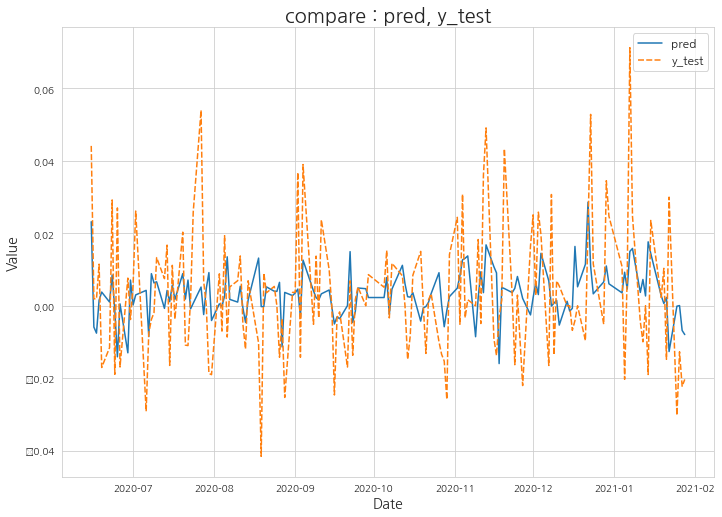

In [44]:
MLP_Regression(len(X.columns), X_train, y_train, X_test, y_test, epochs=10, batch_size=10)